# Characterizing a two-state system

Here is full recipy with example code for the characterization of a two-state system. Data must by given is form of a numpy array, or hdf5 file.

## 1. Use SignalSnap to calculate the polyspectra of a measurement

The documenation of SignalSnap can be found [here](https://github.com/MarkusSifft/SignalSnap). Here, we are only providing a working code example.

In [1]:
from signalsnap import SpectrumCalculator, SpectrumConfig, PlotConfig
import numpy as np
import h5py
import matplotlib.pyplot as plt
import markovanalyzer as ma

Failed to import torch. This is only a problem when you want to use the CUDA backend.


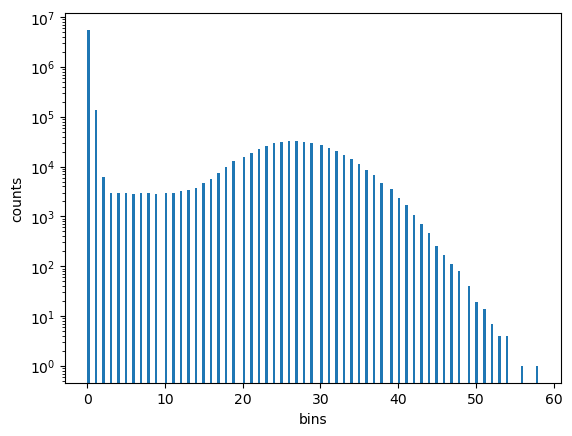

In [2]:
path = 'example_data/long_measurement.h5'
f = h5py.File(path, "r")
group = f['day1']
dataset = group['measurement1'][()] 

_ = plt.hist(dataset, bins=180)
plt.xlabel('bins')
plt.ylabel('counts')
plt.yscale('log')

Text(0.5, 0, 'time (s)')

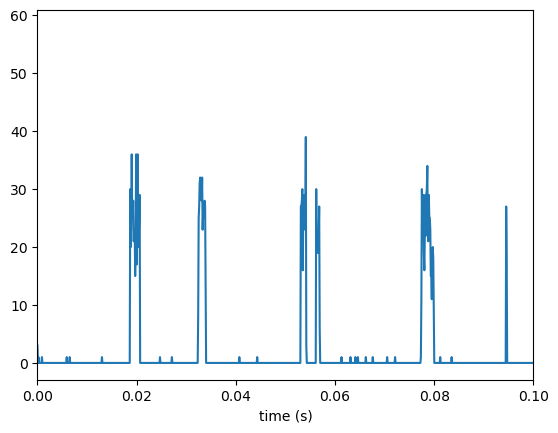

In [3]:
dt = group['measurement1'].attrs['dt'] # sampling time in seconds 
t = np.arange(0,dataset.shape[0]) * dt
plt.plot(t, dataset)
plt.xlim([0,0.1])
plt.xlabel('time (s)')

T_window: 7.450e-02 s
Maximum frequency: 4.993e+03 Hz


  0%|          | 0/829 [00:00<?, ?it/s]

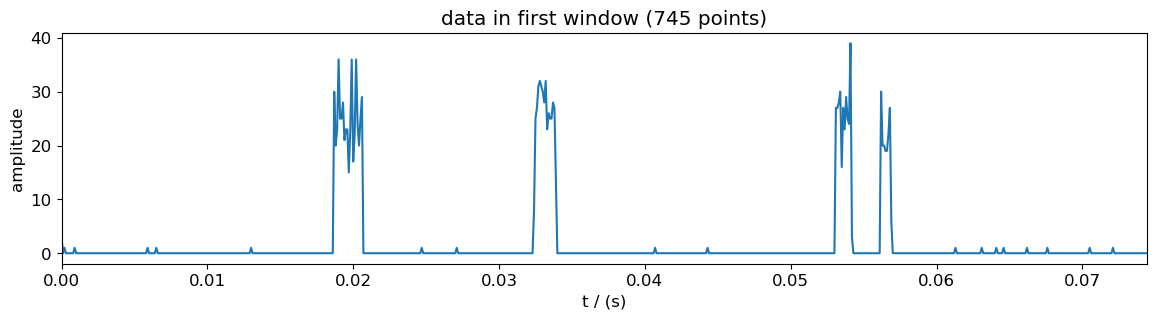

In [7]:
path = 'example_data/long_measurement.h5'
group_key = 'day1'
dataset = 'measurement1'

config = SpectrumConfig(dataset=dataset, group_key=group_key, path=path, f_unit='Hz', 
                        spectrum_size=150, f_max=2000, order_in=[1,2,3,4], 
                        backend='cpu')

spec = SpectrumCalculator(config)

f, s, serr = spec.calc_spec()

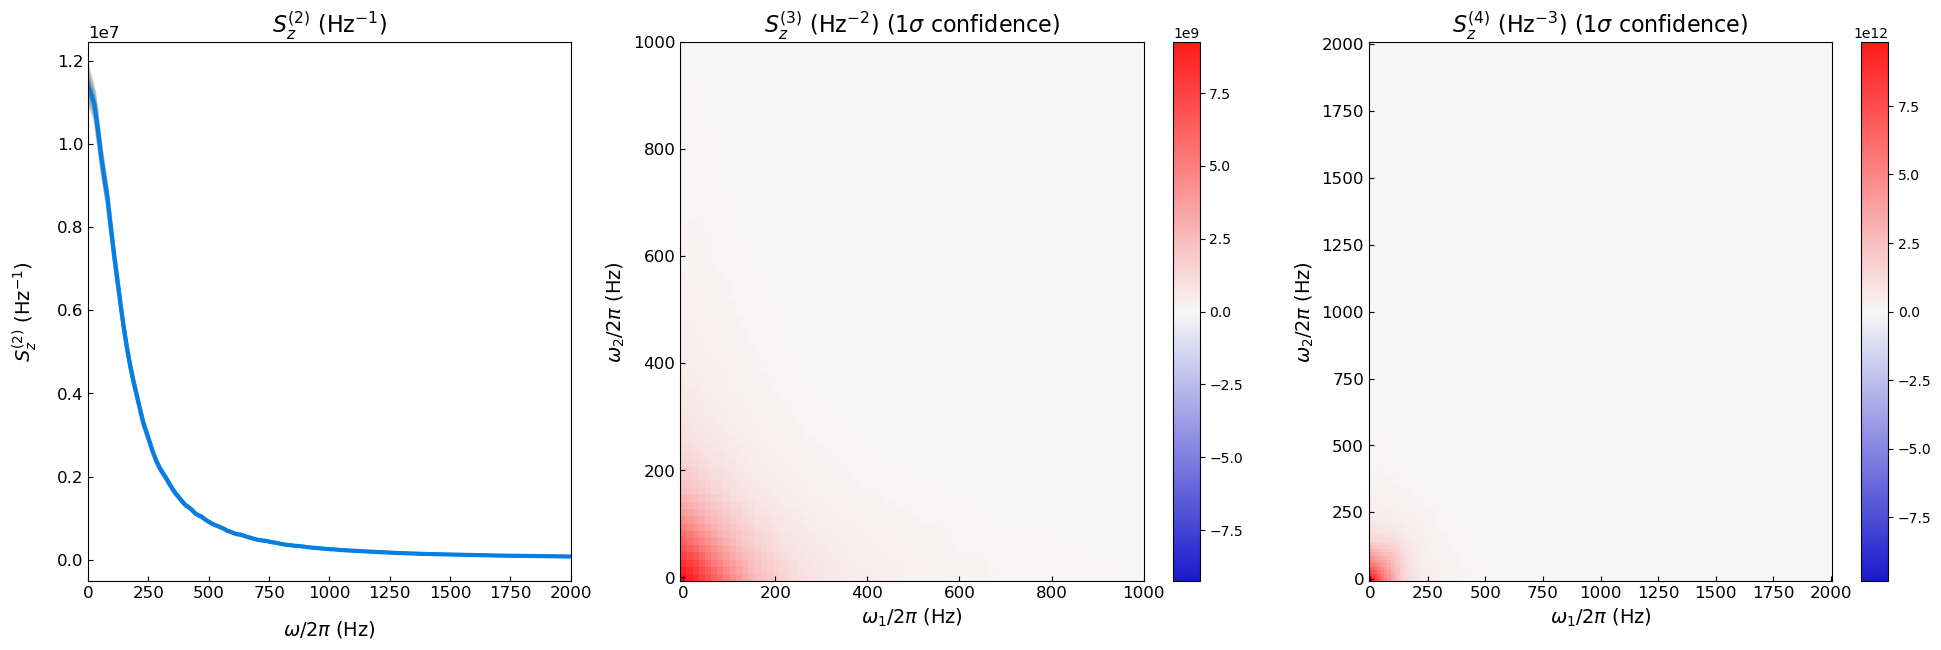

In [8]:
plot_config = PlotConfig(plot_orders=[2,3,4], arcsinh_plot=False, arcsinh_const=0.0002)
fig = spec.plot(plot_config)

In [9]:
path = 'example_data/two_state_example_spectra.pkl'
spec.save_spec(path, remove_S_stationarity=True)

## Characterizing the Two-State Model 

Characterization is performed by fitting the theoretical polyspectra of a Markov model with variable parameters to their experimental counterparts calculated above. We are assuming a two-state model for the system that produced the data; hence, we begin with defining such a model with two variable transition rates.    

The system undergoes transitions from the 0 to 1 state and from the 1 to the 0 state at rates gamma_01 and gamma_10, respectively. Each needs to be associated with a measurement value. From the histogram above we know that the value of the 0 state might be around 0, whereas the value of the 1 state might be around 26. Since we don't know for sure, we leave these measurement values also as variable parameters n_0 and n_1.

In [2]:
def set_system(params):
      
    rates = {'0->1': params['gamma_01'],
             '1->0': params['gamma_10']}
             
    m_op = np.array([params['n_0'],params['n_1']])
    
    markov_system = ma.System(rates, m_op)

    return markov_system

Now, we can set start values and bounds for the fit of the parameters. A parameter c is always part of the fit and acconts for constant white noise outset in the power spectrum.

In [5]:
system_fit = ma.FitSystem(set_system)

parameter = {'gamma_01': [2.0396975e+04, 0, 1e5, True],
             'gamma_10': [1.0345057e+04, 0, 1e5, True],
             'n_0': [0, 0, 1e8, True],
             'n_1': [20, 0, 1e8, True],
             'c': [-2.7651282e-01 , -1e14, 1e14, True]}

path = 'example_data/two_state_example_spectra.pkl'

result = system_fit.complete_fit(path, parameter, 
                        method='least_squares', xtol=1e-6, ftol=1e-6, show_plot=True, fit_modus='order_based',
                        fit_orders=(1,2,3,4), beta_offset=False)

![two level fit](example_data/two_level_final_fit.png)